# VLB Creep Compliance

**Vernerey-Long-Brighenti (VLB) transient network — Creep**

## Context: VLB Creep Response

For a single transient network under constant stress $\sigma_0$, the creep compliance is:

$$J(t) = \frac{1 + k_d t}{G_0} = \frac{1}{G_0} + \frac{t}{\eta_0}$$

Physical picture: chains initially stretch elastically ($J(0) = 1/G_0$), then detach and reform in unstressed configurations, leading to viscous flow ($dJ/dt = 1/\eta_0$). The response is **unbounded** — the material flows indefinitely (liquid behavior).

Adding a permanent network (VLBMultiNetwork with $G_e > 0$) produces a Standard Linear Solid: creep saturates at $J(\infty) = 1/G_e$ (solid-like equilibrium).

> **Handbook:** See [VLB Protocols](../../docs/source/models/vlb/vlb_protocols.rst) for SLS creep derivation, [VLB Knowledge](../../docs/source/models/vlb/vlb_knowledge.rst) for viscosity extraction.

## Learning Objectives

- Understand Maxwell creep compliance: $J(t) = (1 + k_d \cdot t)/G_0$
- Compare single-network (unbounded) vs dual-network (bounded) creep
- Extract $G_0$ and $\eta_0$ from creep data

## Estimated Runtime

- ~1 min

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import VLBLocal, VLBMultiNetwork

jax, jnp = safe_import_jax()
verify_float64()
warnings.filterwarnings("ignore", category=FutureWarning)  # JAX/equinox upstream deprecation churn — not actionable in user notebooks
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

## 2. Theory

### Single network (Maxwell creep)

$$J(t) = \frac{1 + k_d t}{G_0} = \frac{1}{G_0} + \frac{t}{\eta_0}$$

- $J(0) = 1/G_0$ (instantaneous elastic jump)
- $dJ/dt = 1/\eta_0$ (constant viscous flow)
- **Unbounded** — creep continues indefinitely (liquid behavior)

### Dual network (1 transient + permanent = Standard Linear Solid)

$$J(t) = \frac{1}{G_0 + G_e} + \frac{G_0}{G_e(G_0 + G_e)}\left(1 - e^{-t/\tau_{ret}}\right)$$

where $\tau_{ret} = (G_0 + G_e)/(G_e \cdot k_d)$

- $J(0) = 1/(G_0 + G_e)$ (unrelaxed compliance)
- $J(\infty) = 1/G_e$ (relaxed compliance)
- **Bounded** — solid-like equilibrium

## 3. Single Network Creep (Maxwell)

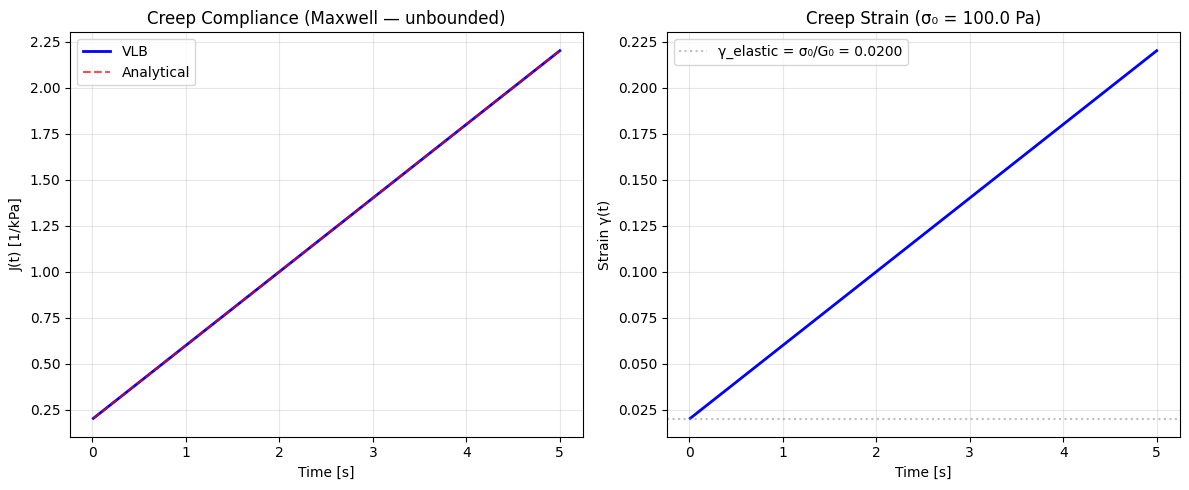

J(0) = 0.2040 1/kPa (expected: 0.2000)
dJ/dt = 0.4000 1/(kPa·s) (expected: 0.4000)


In [3]:
model = VLBLocal()
model.parameters.set_value("G0", 5000.0)
model.parameters.set_value("k_d", 2.0)

sigma_0 = 100.0  # Applied stress [Pa]
t = np.linspace(0.01, 5.0, 500)
gamma, J = model.simulate_creep(t, sigma_0=sigma_0, return_full=True)

# Analytical
J_analytical = (1 + model.k_d * t) / model.G0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(t, J * 1e3, "b-", lw=2, label="VLB")
ax1.plot(t, J_analytical * 1e3, "r--", lw=1.5, alpha=0.7, label="Analytical")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("J(t) [1/kPa]")
ax1.set_title("Creep Compliance (Maxwell — unbounded)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Extract modulus and viscosity from slopes
ax2.plot(t, gamma, "b-", lw=2)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Strain γ(t)")
ax2.set_title(f"Creep Strain (σ₀ = {sigma_0} Pa)")
ax2.axhline(sigma_0 / model.G0, color="gray", linestyle=":", alpha=0.5,
            label=f"γ_elastic = σ₀/G₀ = {sigma_0/model.G0:.4f}")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print(f"J(0) = {J[0]*1e3:.4f} 1/kPa (expected: {1e3/model.G0:.4f})")
print(f"dJ/dt = {(J[-1]-J[0])/(t[-1]-t[0])*1e3:.4f} 1/(kPa·s) (expected: {1e3/model.viscosity:.4f})")

## 4. Dual Network Creep (Standard Linear Solid)

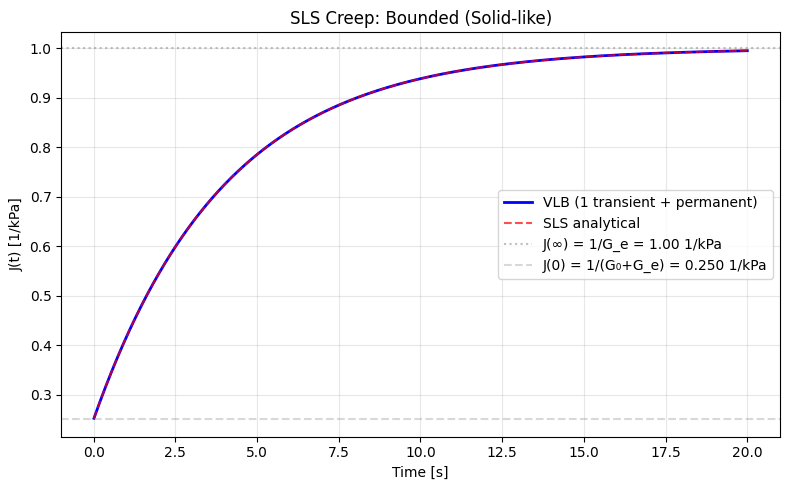

Retardation time τ_ret = 4.00 s
J(0) = 0.2500 1/kPa
J(∞) = 1.0000 1/kPa


In [4]:
model_sls = VLBMultiNetwork(n_modes=1, include_permanent=True)
model_sls.parameters.set_value("G_0", 3000.0)
model_sls.parameters.set_value("k_d_0", 1.0)
model_sls.parameters.set_value("G_e", 1000.0)

G0 = 3000.0
Ge = 1000.0
kd = 1.0

t_sls = np.linspace(0.01, 20.0, 1000)
# VLBMultiNetwork uses predict with test_mode="creep" for creep simulation
gamma_sls = np.asarray(model_sls.predict(t_sls, test_mode="creep", sigma_applied=sigma_0))
J_sls = gamma_sls / sigma_0

# Analytical SLS
tau_ret = (G0 + Ge) / (Ge * kd)
J_unrelaxed = 1.0 / (G0 + Ge)
J_relaxed = 1.0 / Ge
J_sls_analytical = J_unrelaxed + (G0 / (Ge * (G0 + Ge))) * (1 - np.exp(-t_sls / tau_ret))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t_sls, J_sls * 1e3, "b-", lw=2, label="VLB (1 transient + permanent)")
ax.plot(t_sls, J_sls_analytical * 1e3, "r--", lw=1.5, alpha=0.7, label="SLS analytical")
ax.axhline(J_relaxed * 1e3, color="gray", linestyle=":", alpha=0.5,
           label=f"J(∞) = 1/G_e = {J_relaxed*1e3:.2f} 1/kPa")
ax.axhline(J_unrelaxed * 1e3, color="gray", linestyle="--", alpha=0.3,
           label=f"J(0) = 1/(G₀+G_e) = {J_unrelaxed*1e3:.3f} 1/kPa")
ax.set_xlabel("Time [s]")
ax.set_ylabel("J(t) [1/kPa]")
ax.set_title("SLS Creep: Bounded (Solid-like)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Retardation time τ_ret = {tau_ret:.2f} s")
print(f"J(0) = {J_unrelaxed*1e3:.4f} 1/kPa")
print(f"J(∞) = {J_relaxed*1e3:.4f} 1/kPa")

## 5. Fit Creep Data

In [5]:
# Generate noisy Maxwell creep data
np.random.seed(42)
t_creep = np.linspace(0.01, 5.0, 40)
J_true = (1 + 2.0 * t_creep) / 5000.0
J_noisy = J_true * (1 + 0.02 * np.random.randn(len(t_creep)))
gamma_data = J_noisy * sigma_0

model_fit = VLBLocal()
model_fit.fit(t_creep, gamma_data, test_mode="creep", sigma_applied=sigma_0)

print(f"G₀  = {model_fit.G0:.1f} Pa (true: 5000)")
print(f"k_d = {model_fit.k_d:.4f} 1/s (true: 2.0)")
print(f"η₀  = {model_fit.viscosity:.1f} Pa·s (true: 2500)")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.757692s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=8 | final_cost=0.0064 | elapsed=0.758s | final_gradient_norm=3.5779e-09


G₀  = 4914.9 Pa (true: 5000)
k_d = 1.9417 1/s (true: 2.0)
η₀  = 2531.2 Pa·s (true: 2500)


## Key Takeaways

1. **Maxwell creep: $J(t) = 1/G_0 + t/\eta_0$** — linear, unbounded (liquid)
2. **SLS creep: bounded** — approaches $J(\infty) = 1/G_e$ (solid with permanent network)
3. **$J(0) = 1/G_0$** gives instantaneous modulus
4. **$dJ/dt = 1/\eta_0$** gives zero-shear viscosity

## Further Reading

- [VLB Model Reference](../../docs/source/models/vlb/vlb.rst) — creep compliance equations, SLS analytical solution
- [VLB Protocols](../../docs/source/models/vlb/vlb_protocols.rst) — retardation time derivation
- Vernerey, F.J., Long, R. & Brighenti, R. (2017). *J. Mech. Phys. Solids*, 107, 1-20.

## Next Steps

- **Notebook 05**: SAOS fitting (primary VLB use case)
- **Notebook 07**: Full Bayesian workflow